In [274]:
# Part 1: Iris Classification

# Getting the Dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import torch

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


In [275]:
# Visualize the Data
df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


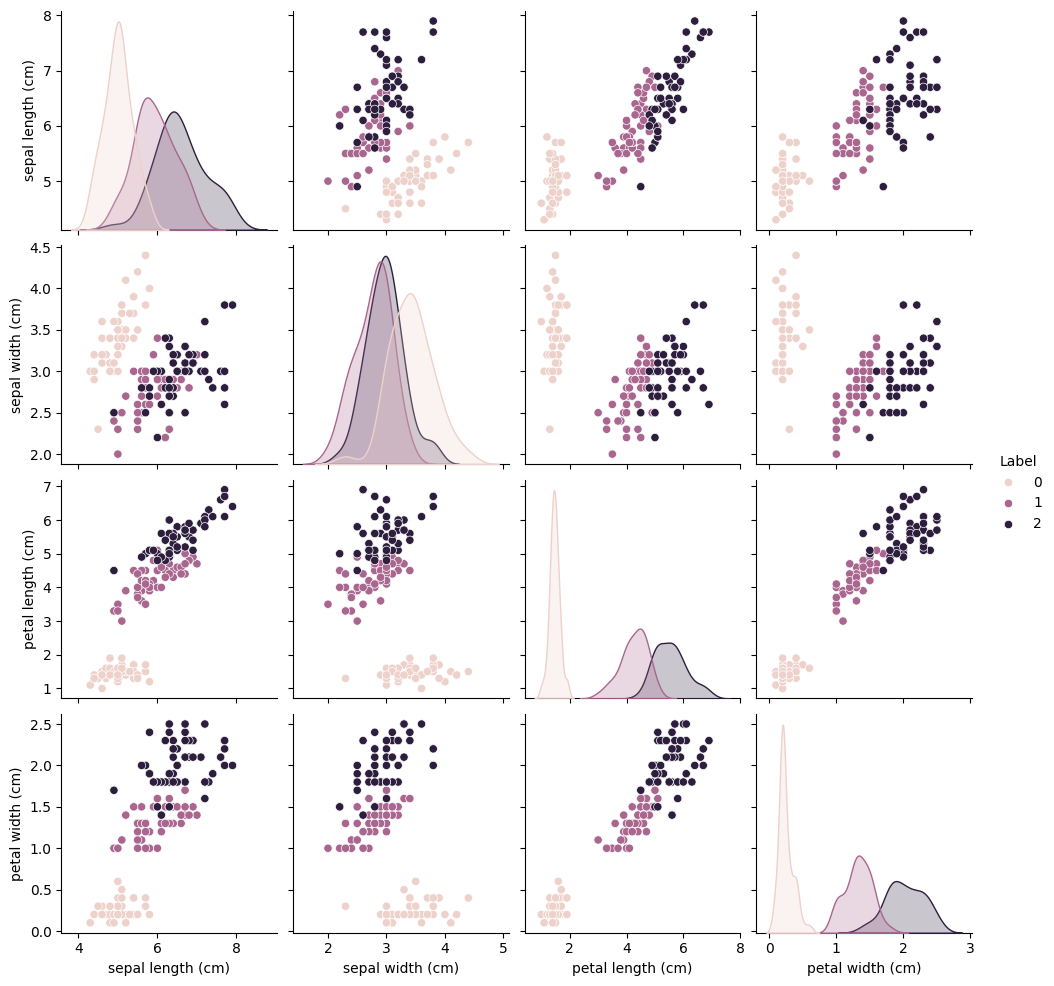

In [276]:
sns.pairplot(df,hue='Label')

In [277]:
# Code to normalize and encode the data
features_n = sklearn.preprocessing.normalize(features, return_norm=False)
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]


In [278]:
# Split the data
features_train, features_test, labels_train, labels_test = sklearn.model_selection.train_test_split(features_n,labels_onehot)

In [279]:
# Define the network

class MyNet(torch.nn.Module):   # inherited from torch.nn.Module
    def __init__(self,hidden_size=30,func=torch.nn.ReLU()):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,hidden_size,dtype=float)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_size,3,dtype=float)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        return torch.Tensor(x)  # Make sure x is a tensor

net = MyNet(func=torch.nn.ReLU())
print(net)


MyNet(
  (fc1): Linear(in_features=4, out_features=30, bias=True)
  (func): ReLU()
  (fc2): Linear(in_features=30, out_features=3, bias=True)
)


In [280]:
num_classes = 3

dataset = torch.utils.data.TensorDataset(torch.tensor(features_train),torch.tensor(labels_train,dtype=torch.float64))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16)

list(dataloader)[0]

[tensor([[0.7156, 0.3523, 0.5615, 0.2202],
         [0.7724, 0.3371, 0.5196, 0.1404],
         [0.8251, 0.5281, 0.1980, 0.0330],
         [0.7568, 0.3523, 0.5350, 0.1305],
         [0.6702, 0.3617, 0.5957, 0.2553],
         [0.7326, 0.3603, 0.5525, 0.1681],
         [0.7315, 0.2850, 0.5795, 0.2185],
         [0.7297, 0.2895, 0.5791, 0.2201],
         [0.7471, 0.3396, 0.5434, 0.1766],
         [0.7647, 0.3149, 0.5398, 0.1574],
         [0.7324, 0.3855, 0.5397, 0.1542],
         [0.7859, 0.5702, 0.2312, 0.0616],
         [0.6905, 0.3215, 0.6072, 0.2262],
         [0.7172, 0.3164, 0.5801, 0.2215],
         [0.7345, 0.3737, 0.5412, 0.1675],
         [0.7078, 0.3185, 0.6016, 0.1887]], dtype=torch.float64),
 tensor([[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         [0.,

In [281]:
# Train the network

def train(net, dataloader, val_x, val_lab, epochs=10, lr=0.05):

    epoch_data = []
    optim = torch.optim.Adam(net.parameters(), lr=lr)

    for ep in range(epochs):
        for (x, y) in dataloader:
            optim.zero_grad()
            z = net(x)
            loss = torch.nn.functional.cross_entropy(z, y) 
            loss.backward()
            optim.step()

        # Calculate validation accuracy
        with torch.no_grad():
            predictions = net(val_x)
           
            val_acc = calculate_accuracy(predictions, val_lab)
        
        epoch_data.append([loss,val_acc])
        print(f"Epoch {ep}: last batch loss = {loss}, val acc = {val_acc}")

    return epoch_data


In [282]:
def calculate_accuracy(predictions,val_lab):
    count = 0.0
    for i in range(predictions.size()[0]):
        predict = predictions[i].argmax()
        if (predict == val_lab[i].argmax()):
            count += 1
    return count/predictions.size()[0]

In [283]:
feat_tensor = torch.tensor(features_test)
lab_tensor = torch.tensor(labels_test)

loss_acc=train(net,dataloader,feat_tensor,lab_tensor,lr=0.05)


Epoch 0: last batch loss = 0.9336488069109955, val acc = 0.631578947368421
Epoch 1: last batch loss = 0.5488911066627095, val acc = 0.7631578947368421
Epoch 2: last batch loss = 0.37093811134064064, val acc = 0.9210526315789473
Epoch 3: last batch loss = 0.28013733417528985, val acc = 0.9210526315789473
Epoch 4: last batch loss = 0.2291421362514021, val acc = 0.9736842105263158
Epoch 5: last batch loss = 0.16698974141554562, val acc = 0.9736842105263158
Epoch 6: last batch loss = 0.11607563805158512, val acc = 0.9736842105263158
Epoch 7: last batch loss = 0.08248915188245201, val acc = 0.9736842105263158
Epoch 8: last batch loss = 0.06135602061833561, val acc = 0.9736842105263158
Epoch 9: last batch loss = 0.04789414771115306, val acc = 0.9736842105263158


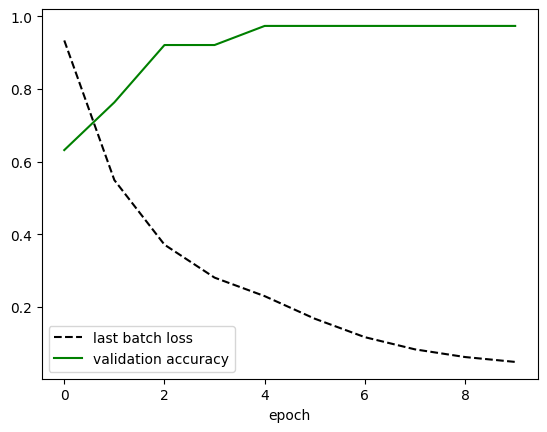

In [284]:
# Visualize train/validation accuracy graph

def plot_training_loss_acc(loss_acc):
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('epoch')
    ax.legend(ax.lines, ['last batch loss', 'validation accuracy'], loc='upper center', ncol = 2)

    loss_list=[]
    acc_list=[]
    for epoch in loss_acc:
        try:
            loss_list.append(epoch[0].detach_())
        except AttributeError:
            loss_list.append(epoch[0])
        try:
            acc_list.append(epoch[1].detach_())
        except AttributeError:
            acc_list.append(epoch[1]) 

    ax.plot(range(len(loss_acc)), loss_list, 'k--', label='last batch loss')
    ax.plot(range(len(loss_acc)), acc_list, 'g-', label='validation accuracy')

    plt.legend()
    plt.show()
    
plot_training_loss_acc(loss_acc)

Epoch 0: last batch loss = 1.0945009369270255, val acc = 0.631578947368421
Epoch 1: last batch loss = 0.9613973820247619, val acc = 0.6578947368421053
Epoch 2: last batch loss = 0.8738677695836258, val acc = 0.631578947368421
Epoch 3: last batch loss = 0.8165768531722412, val acc = 0.6842105263157895
Epoch 4: last batch loss = 0.7659950044429026, val acc = 0.8157894736842105
Epoch 5: last batch loss = 0.7127352213822253, val acc = 0.8157894736842105
Epoch 6: last batch loss = 0.6650742523494919, val acc = 0.7368421052631579
Epoch 7: last batch loss = 0.6288612612703448, val acc = 0.7631578947368421
Epoch 8: last batch loss = 0.6010245003959198, val acc = 0.8157894736842105
Epoch 9: last batch loss = 0.5760321004955485, val acc = 0.8157894736842105


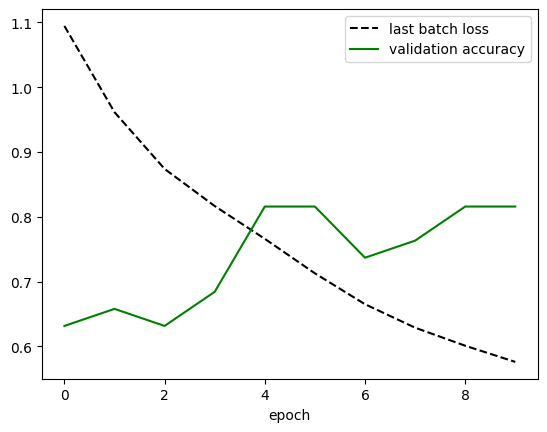

In [285]:
# Experiment

# One-layer network with 3 neurons (equal to the number of classes) 

class MyNet1(torch.nn.Module):   # inherited from torch.nn.Module
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,3,dtype=float)

    def forward(self,x):
        x = self.fc1(x)
        return torch.Tensor(x)  # Make sure x is a tensor

net1 = MyNet1()

loss_acc1=train(net1,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc1)

Epoch 0: last batch loss = 1.1125627136637903, val acc = 0.3684210526315789
Epoch 1: last batch loss = 0.965440560187284, val acc = 0.631578947368421
Epoch 2: last batch loss = 0.8110339038585719, val acc = 0.631578947368421
Epoch 3: last batch loss = 0.681219770880471, val acc = 0.631578947368421
Epoch 4: last batch loss = 0.5839021827214665, val acc = 0.6578947368421053
Epoch 5: last batch loss = 0.5031583245714134, val acc = 0.6842105263157895
Epoch 6: last batch loss = 0.43998047777958005, val acc = 0.6578947368421053
Epoch 7: last batch loss = 0.40356968720382946, val acc = 0.7368421052631579
Epoch 8: last batch loss = 0.38094981666119077, val acc = 0.7894736842105263
Epoch 9: last batch loss = 0.3633507027211396, val acc = 0.7894736842105263


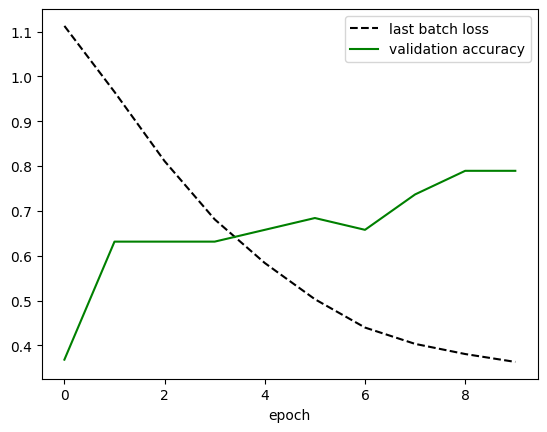

In [286]:
# Two-layer network with small/medium/large hidden layer

# small
net21 = MyNet(hidden_size=8,func=torch.nn.ReLU())

loss_acc21=train(net21,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc21)


Epoch 0: last batch loss = 0.9039972490971824, val acc = 0.34210526315789475
Epoch 1: last batch loss = 0.5607747210756066, val acc = 0.868421052631579
Epoch 2: last batch loss = 0.3622046666350292, val acc = 0.9210526315789473
Epoch 3: last batch loss = 0.2682017743094211, val acc = 0.9210526315789473
Epoch 4: last batch loss = 0.21768377393954735, val acc = 0.9736842105263158
Epoch 5: last batch loss = 0.153825869622188, val acc = 0.9736842105263158
Epoch 6: last batch loss = 0.10461920824690205, val acc = 0.9736842105263158
Epoch 7: last batch loss = 0.07471848235250043, val acc = 0.9736842105263158
Epoch 8: last batch loss = 0.05511178275807469, val acc = 1.0
Epoch 9: last batch loss = 0.0407640168246531, val acc = 0.9736842105263158


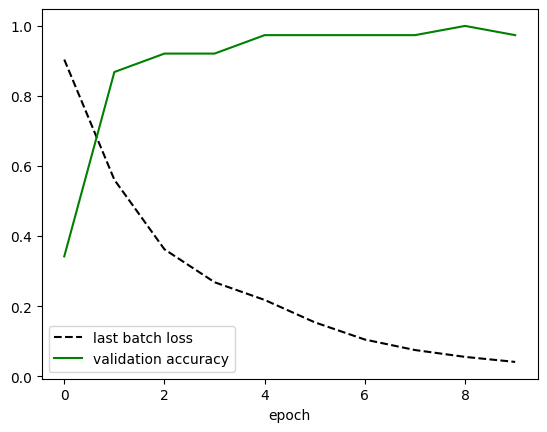

In [287]:
# medium
net22 = MyNet(hidden_size=32,func=torch.nn.ReLU())

loss_acc22=train(net22,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc22)

Epoch 0: last batch loss = 0.8511301588244693, val acc = 0.631578947368421
Epoch 1: last batch loss = 0.5347792487106434, val acc = 0.9473684210526315
Epoch 2: last batch loss = 0.35251781074844135, val acc = 0.9736842105263158
Epoch 3: last batch loss = 0.23817053326397927, val acc = 0.8947368421052632
Epoch 4: last batch loss = 0.17898894660757417, val acc = 0.9210526315789473
Epoch 5: last batch loss = 0.12150898278301772, val acc = 0.9736842105263158
Epoch 6: last batch loss = 0.0860599057273622, val acc = 0.9736842105263158
Epoch 7: last batch loss = 0.06922738368885448, val acc = 0.9736842105263158
Epoch 8: last batch loss = 0.05242725328479289, val acc = 0.8947368421052632
Epoch 9: last batch loss = 0.03226759300184885, val acc = 0.9736842105263158


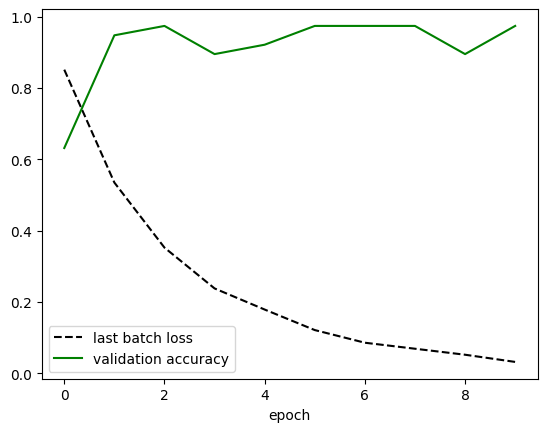

In [288]:
# large
net23 = MyNet(hidden_size=64,func=torch.nn.ReLU())

loss_acc23=train(net23,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc23)

Epoch 0: last batch loss = 0.8566208473383983, val acc = 0.631578947368421
Epoch 1: last batch loss = 0.3378111118718835, val acc = 0.7631578947368421
Epoch 2: last batch loss = 0.2256351308673078, val acc = 0.8947368421052632
Epoch 3: last batch loss = 0.12403748323773287, val acc = 0.9473684210526315
Epoch 4: last batch loss = 0.20269104836140248, val acc = 1.0
Epoch 5: last batch loss = 0.022208735786799872, val acc = 0.9736842105263158
Epoch 6: last batch loss = 0.16076133374113113, val acc = 0.8947368421052632
Epoch 7: last batch loss = 0.005237465506702967, val acc = 0.9210526315789473
Epoch 8: last batch loss = 0.05650780409438957, val acc = 0.8157894736842105
Epoch 9: last batch loss = 0.060261539384882594, val acc = 0.8947368421052632


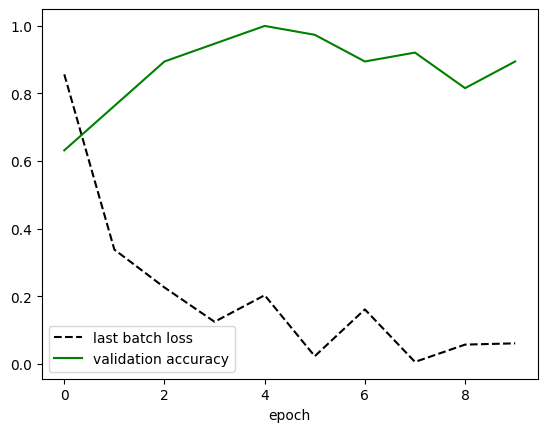

In [289]:
# Using more layers

class MyNet3(torch.nn.Module):   # inherited from torch.nn.Module
    def __init__(self,hidden_size1=15,hidden_size2=30,func1=torch.nn.ReLU(),func2=torch.nn.LeakyReLU(negative_slope=0.2)):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,hidden_size1,dtype=float)
        self.func1 = func1
        self.fc2 = torch.nn.Linear(hidden_size1,hidden_size2,dtype=float)
        self.func2 = func2  # Leaky ReLU
        self.fc3 = torch.nn.Linear(hidden_size2,3,dtype=float)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func1(x)
        x = self.fc2(x)
        x = self.func2(x)
        x = self.fc3(x)        
        return torch.Tensor(x)  # Make sure x is a tensor

net3 = MyNet3()

loss_acc3=train(net3,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc3)


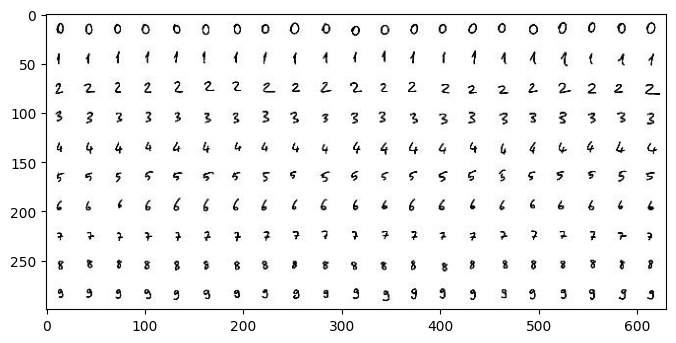

In [290]:
# MNIST Training but make id DIY

from PIL import Image
from pathlib import Path
%matplotlib inline 

# Load the dataset
fileName = 'myMnist.jpg'
imageJPG = Image.open(fileName,mode='r',formats=None)
fileNamePNG = 'myMnist.png'
imageJPG.save(fileNamePNG)
imagePNG = Image.open(fileNamePNG,mode='r',formats=None)

def show(img, figsize=(8, 4), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

show(imagePNG)


In [291]:
print(f'Image details')
print(f'Format {imagePNG.format}')
print(f'Size {imagePNG.size}')
print(f'Mode {imagePNG.mode}')

Image details
Format PNG
Size (630, 300)
Mode RGB


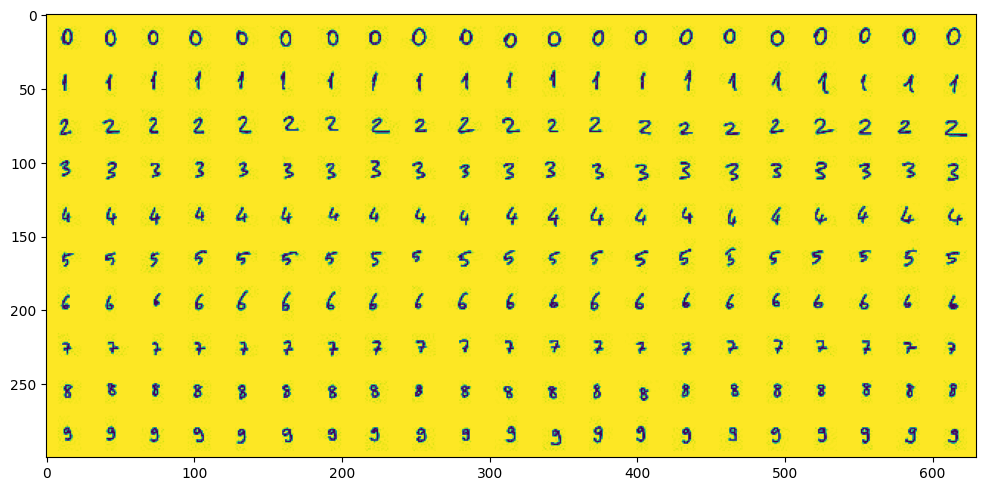

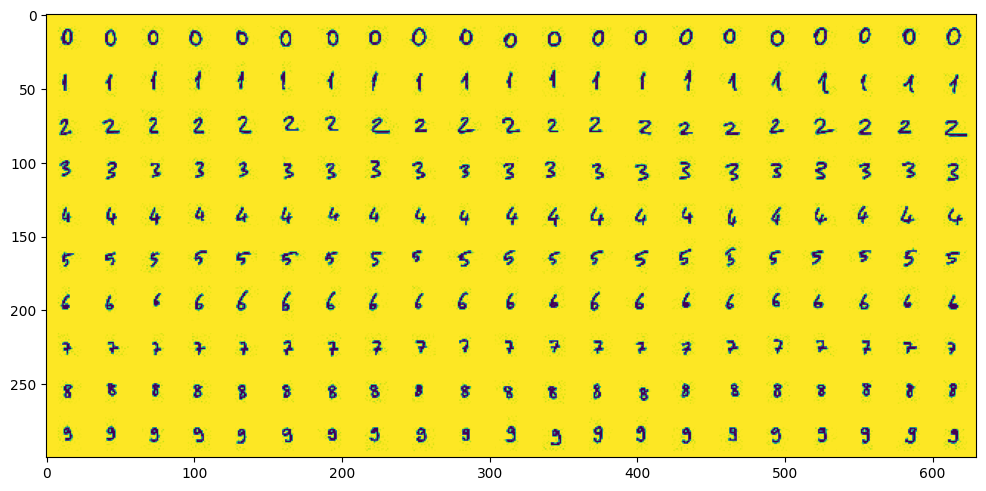

In [310]:
# Change color mode to black-and-white, 256 shades

from PIL import ImageEnhance

bw_image = imagePNG.convert(mode='L') 
show(bw_image, figsize=(12, 12))
bw_image = ImageEnhance.Contrast(bw_image).enhance(1.5)
show(bw_image, figsize=(12, 12))

# Threshold the grayscale image
threshold = 150  # Adjust this value based on your image
thresholded_image = bw_image.point(lambda p: p > threshold and 255)


In [311]:
# Cut square images 30x30 pixels each.
# Image size is (630, 300) and there are 10 rows with 30 elements in it.

SIZE = 30

samples = [] #array to store cut images
for digit, y in enumerate(range(0, thresholded_image.height, SIZE)):
    cuts=[]
    for x in range(0, thresholded_image.width, SIZE):
        cut = thresholded_image.crop(box=(x, y, x+SIZE, y+SIZE))
        cuts.append(cut)
    samples.append(cuts)
print(f'Cut {len(samples)*len(samples[0])} images total.')


Cut 210 images total.


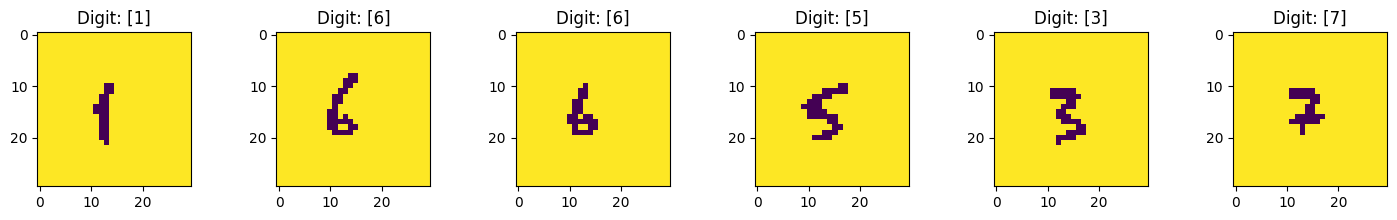

In [312]:
f = plt.figure(figsize=(18,2))
ax = f.subplots(1, 6)
for i, n in enumerate(np.random.randint(0, len(samples), size=6)):
    m = (np.random.randint(0, len(samples[n])))
    ax[i].imshow(samples[n][m])
    ax[i].set_title(f'Digit: [{n}]')
plt.show()

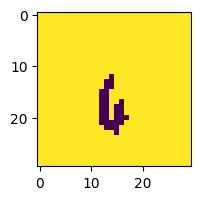

In [313]:
# Center images
from PIL import ImageOps
import matplotlib.patches as patches

sample = samples[4][15]
show(sample, figsize=(2, 2))

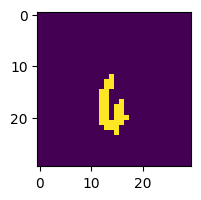

In [315]:
def invert(im):
    if im.mode in {'P', 'PA'}:
        pmode, pal = im.palette.getdata()
        pal = Image.frombytes(pmode, (len(pal) // len(pmode), 1), pal)
        im = im.copy()
        im.palette.palette = invert(pal).tobytes()
        return im
    elif im.mode in {'LA', 'La', 'RGBA', 'RGBa', 'RGBX'}:
        return im.point([*range(255, -1, -1)] * (len(im.mode) - 1) + [*range(256)])
    else:
        # This may fail
        return im.point(lambda x: 255-x)

# Inver sample, get bbox and display all that stuff.
inv_sample = invert(sample)
show(inv_sample, figsize=(2, 2))


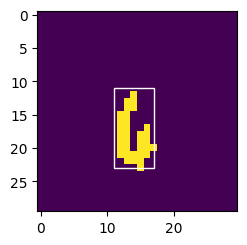

In [316]:
bbox = inv_sample.getbbox()

fig = plt.figure(figsize=(2, 2))
ax = fig.add_axes([0,0,1,1])

ax.imshow(inv_sample)

width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]

rect = patches.Rectangle((bbox[0]-1, bbox[1]-1), width, height, fill=False, alpha=1, edgecolor='w')

ax.add_patch(rect)
plt.show()

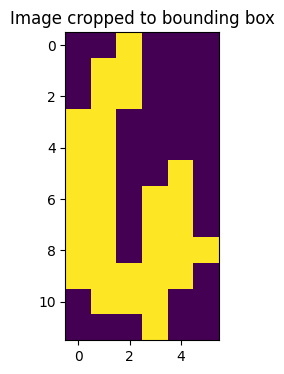

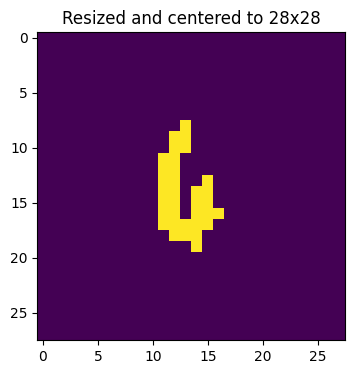

In [322]:
crop = inv_sample.crop(bbox)
show(crop, title='Image cropped to bounding box')

#resize back
new_size = 28
delta_w = new_size - crop.size[0]
delta_h = new_size - crop.size[1]
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
new_im = ImageOps.expand(crop, padding)
show(new_im, title='Resized and centered to 28x28')

In [323]:
def resize_and_center(sample, new_size=28):
    inv_sample = ImageOps.invert(sample)
    bbox = inv_sample.getbbox()
    crop = inv_sample.crop(bbox)
    delta_w = new_size - crop.size[0]
    delta_h = new_size - crop.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(crop, padding)

resized_samples = []
for row in samples:
    resized_samples.append([resize_and_center(sample) for sample in row])

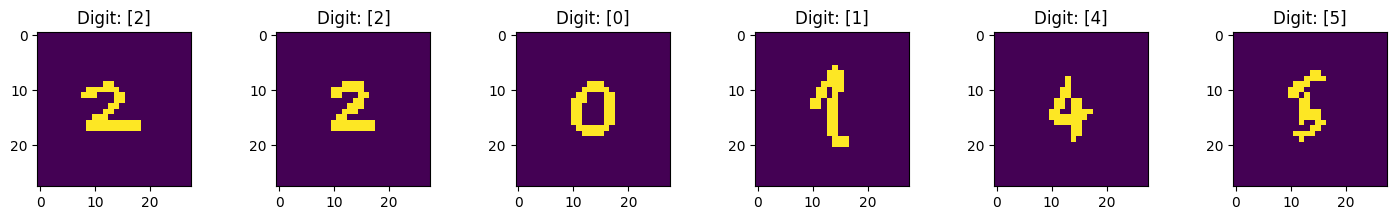

In [324]:
f = plt.figure(figsize=(18,2))
ax = f.subplots(1, 6)
for i, n in enumerate(np.random.randint(0, len(resized_samples), size=6)):
    m = (np.random.randint(0, len(resized_samples[n])))
    ax[i].imshow(resized_samples[n][m])
    ax[i].set_title(f'Digit: [{n}]')
plt.show()

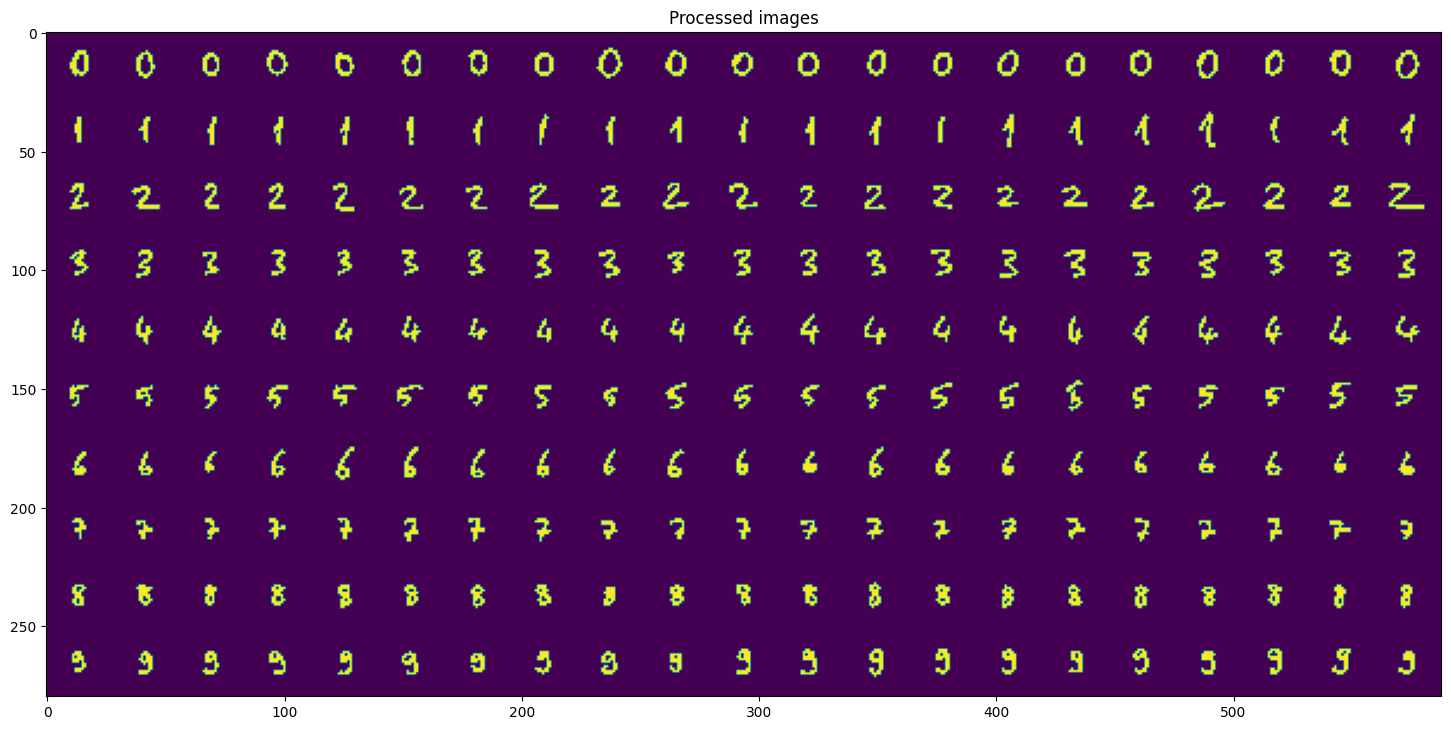

In [340]:
preview = Image.new('L', (len(samples[0])*new_size, len(samples)*new_size))


x = 0
y = 0
for row in resized_samples:
    for sample in row:
        preview.paste(sample, (x, y))
        x += new_size
    y+=new_size
    x = 0

show(preview, figsize=(18,18), title='Processed images')
preview.save('preview.png')

In [341]:
binary_samples = np.array([[sample.getdata() for sample in row] for row in resized_samples])
binary_samples = binary_samples.reshape(len(resized_samples)*len(resized_samples[0]), 28, 28)

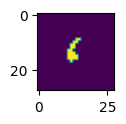

In [342]:
show(binary_samples[128], figsize=(1,1))

In [343]:
classes = np.array([[i]*21 for i in range(10)]).reshape(-1)

In [344]:
print(f'X shape: {binary_samples.shape}')
print(f'y shape: {classes.shape}')

X shape: (210, 28, 28)
y shape: (210,)


In [345]:
xfile = 'digits_x_test.npy'
yfile = 'digits_y_test.npy'
np.save(xfile, binary_samples)
np.save(yfile, classes)

In [346]:
x_test = np.load(xfile)
y_test = np.load(yfile)
x_test.shape, y_test.shape

((210, 28, 28), (210,))

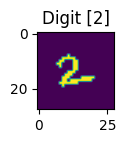

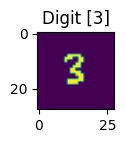

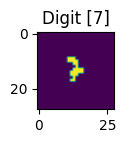

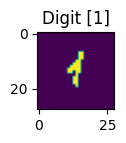

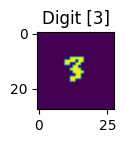

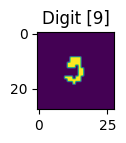

In [347]:
for i in np.random.randint(x_test.shape[0], size=6):
    show(x_test[i], title=f'Digit [{y_test[i]}]', figsize=(1,1))